# Imports

In [40]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import (RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor as XGBR
from lightgbm import LGBMRegressor as LGBMR; 
from catboost import CatBoostRegressor as CBR
import warnings
warnings.filterwarnings('ignore')

# Reading the Data

We read the data and see that the training data has over four thousand rows and thirty three features.

Insight: 

1. Avoid algorithm that suffers from the curse of dimensionality(KNN, etc)
2. At some point we will need to use dimensionality reduction technique(PCA, t-SNE) or remove useless features.

In [2]:
train_data = pd.read_csv('../data/train_test_data/train.csv')
test_data = pd.read_csv('../data/train_test_data/test.csv')

train_data.shape

(4120, 33)

In [3]:
train_data.head()

,id,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,0,1.0,27.323000,14.823000,20.573002,25.777689,14.690771,19.505260,0,0,...,10.4179,32.275000,324.541667,1.706250,1.164583,90.208333,0.277083,9.916667,2.185417,2.189583
1,1,1.0,29.528000,17.528000,23.321753,32.480470,18.525795,24.953913,0,0,...,13.6833,12.837500,312.500000,0.118750,0.231250,57.791667,0.343333,2.958333,1.581250,1.979167
2,2,65.0,23.773000,15.323000,18.233418,24.630080,16.138641,19.608873,0,0,...,10.4179,20.445833,232.000000,1.827083,0.347917,54.416667,0.249167,16.625000,1.970833,2.566667
3,3,1.0,32.478000,19.227999,25.419668,35.235100,21.212915,27.534365,0,0,...,13.6833,30.583333,381.375000,0.358333,0.491667,53.958333,0.446667,3.333333,2.075000,2.218750
4,4,3.0,39.858498,28.508501,33.854332,42.387520,30.281784,35.202442,0,0,...,13.4000,38.733333,307.833333,1.429167,0.454167,61.500000,0.697500,74.916667,1.783333,2.170833


In [4]:
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(0, 0)

In [5]:
train_data.duplicated().sum().sum(), test_data.duplicated().sum().sum()

(0, 0)

No null values, no duplicates, the dataset appear to be relatively clean.

# Target Distribution

The target distribution appear to be skewed to the right, this indicates the presence of outliers.The highest value for pm2_5 is 172.8291 for the city of Bertoua.

<Figure size 1200x600 with 0 Axes>

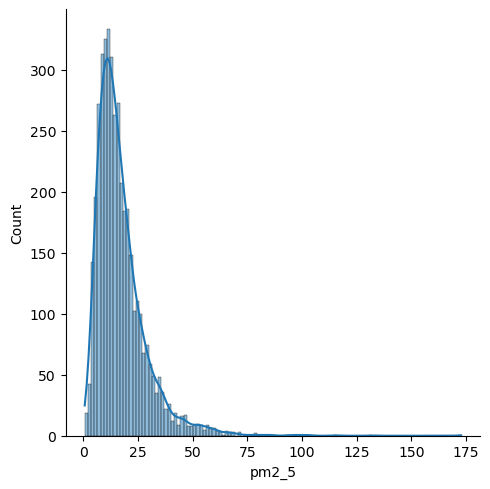

In [6]:

plt.figure(figsize = (12, 6))
sns.displot(train_data['pm2_5'], kde = True)
plt.show()

We can understand a little bit more the overall air quality by creating categories: 

- Good: pm2_5 < 12.5
- Fair: pm2_5 [12.5–25]
- Poor: pm2_5 	[25–50]
- Very poor: pm2_5 [50–150]
- Extremely poor: pm2_5 More than 150


<Axes: xlabel='category', ylabel='Count'>

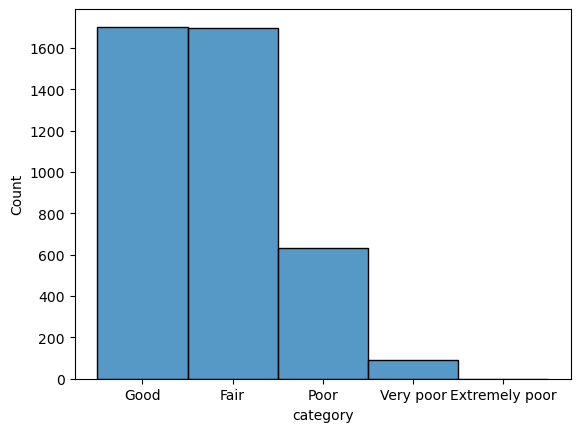

In [7]:
train_data['category'] = pd.cut(train_data['pm2_5'], 
                        bins=[-float('inf'), 12.5, 25, 50, 150, float('inf')], 
                        labels=['Good', 'Fair', 'Poor', 'Very poor', 'Extremely poor'])

sns.histplot(train_data['category'])

The vast majority of sample fall under the Good and Fair category, meaning that the air quality is usually of that quality in Cameroon.

In [8]:
train_data.groupby('city')['pm2_5'].mean()

city
Bafoussam     21.769081
Bamenda       20.146944
Bertoua       17.205552
Buea          13.955294
Douala        16.375233
Ebolowa       10.882733
Garoua        21.008722
Maroua        18.974740
Ngaoundéré    14.738632
Yaoundé       16.215085
Name: pm2_5, dtype: float64

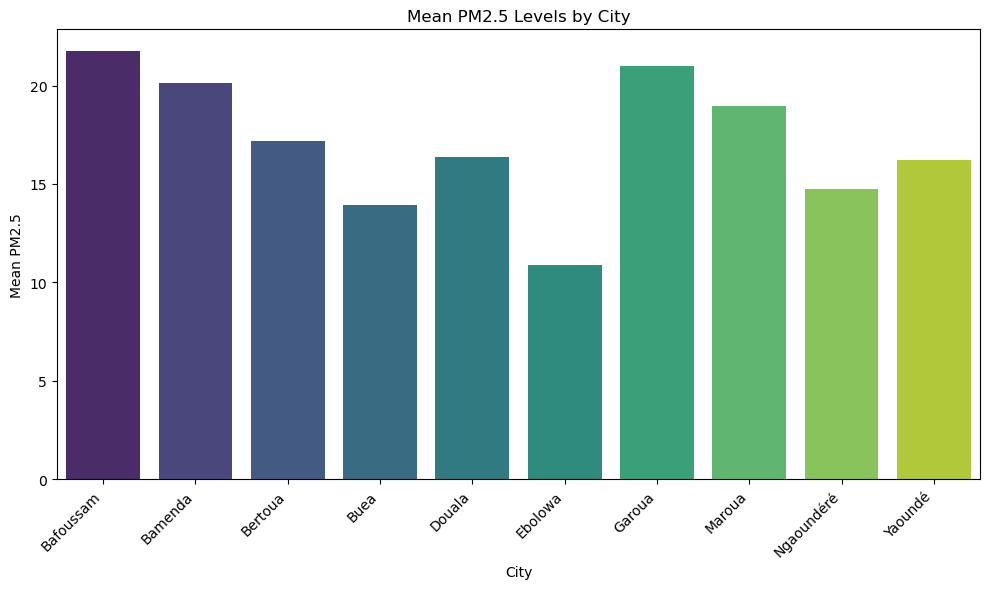

In [9]:
mean_pm2_5_by_city = train_data.groupby('city')['pm2_5'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='pm2_5', data=mean_pm2_5_by_city, palette='viridis')
plt.title('Mean PM2.5 Levels by City')
plt.xlabel('City')
plt.ylabel('Mean PM2.5')
plt.xticks(rotation=45, ha='right')  # Rotate city names for better readability
plt.tight_layout()

# Show the plot
plt.show()

On average the air quality amongs the different cities in Cameroon is fair.

Features like sunrise, sunset, snowfall_sum are non existent in a country like Cameroon, that's why all the values for these features are 0. They are constant so we can delete them

In [10]:
train_data.drop(['sunset', 'snowfall_sum', 'sunrise'], axis = 1, inplace = True)
test_data.drop(['sunset', 'snowfall_sum', 'sunrise'], axis = 1, inplace = True)

# Feature Distribution

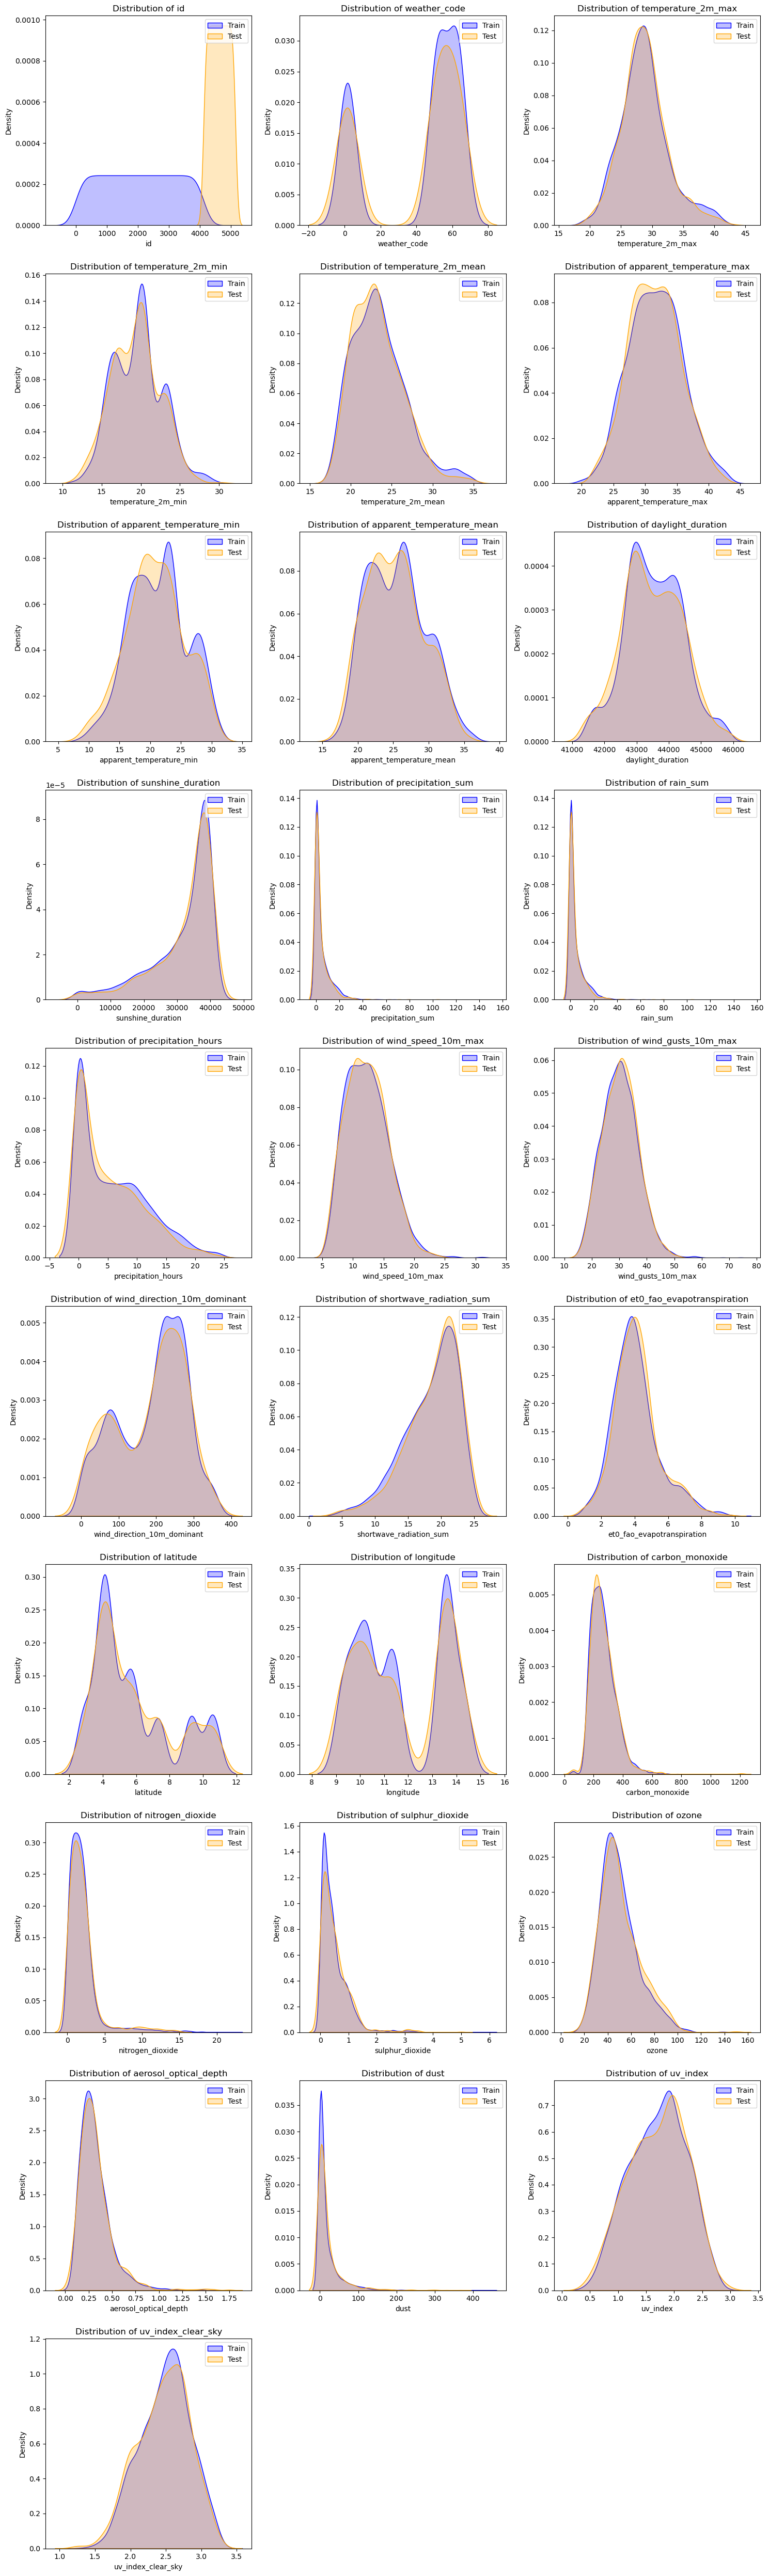

In [11]:
# Create a figure with subplots for each feature
features = list(test_data.select_dtypes(['Int64', 'float64'])) # List of all features in your dataset
n_features = len(features)  # Number of features to plot

# Number of columns per row (3 features per row)
n_cols = 3
# Number of rows, calculated by dividing the total features by the number of columns
n_rows = math.ceil(n_features / n_cols)

# Set up the figure with subplots (n_rows x n_cols grid)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size

# Flatten the axes array for easy iteration, if needed
axes = axes.flatten()

# Iterate through each feature and plot its distribution for train and test sets
for i, feature in enumerate(features):
    ax = axes[i]
    
    # Plot the distribution of the feature in the train set
    sns.kdeplot(train_data[feature], ax=ax, label='Train', color='blue', fill=True)
    
    # Plot the distribution of the feature in the test set
    sns.kdeplot(test_data[feature], ax=ax, label='Test', color='orange', fill=True)
    
    # Set plot labels and title
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Remove any empty subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

The distribution of data in the train and test set appear to be relatively the same. We observe that some features are right and left skewed distributed. We can use log transformation to deal with that.

# Correlations

<Axes: >

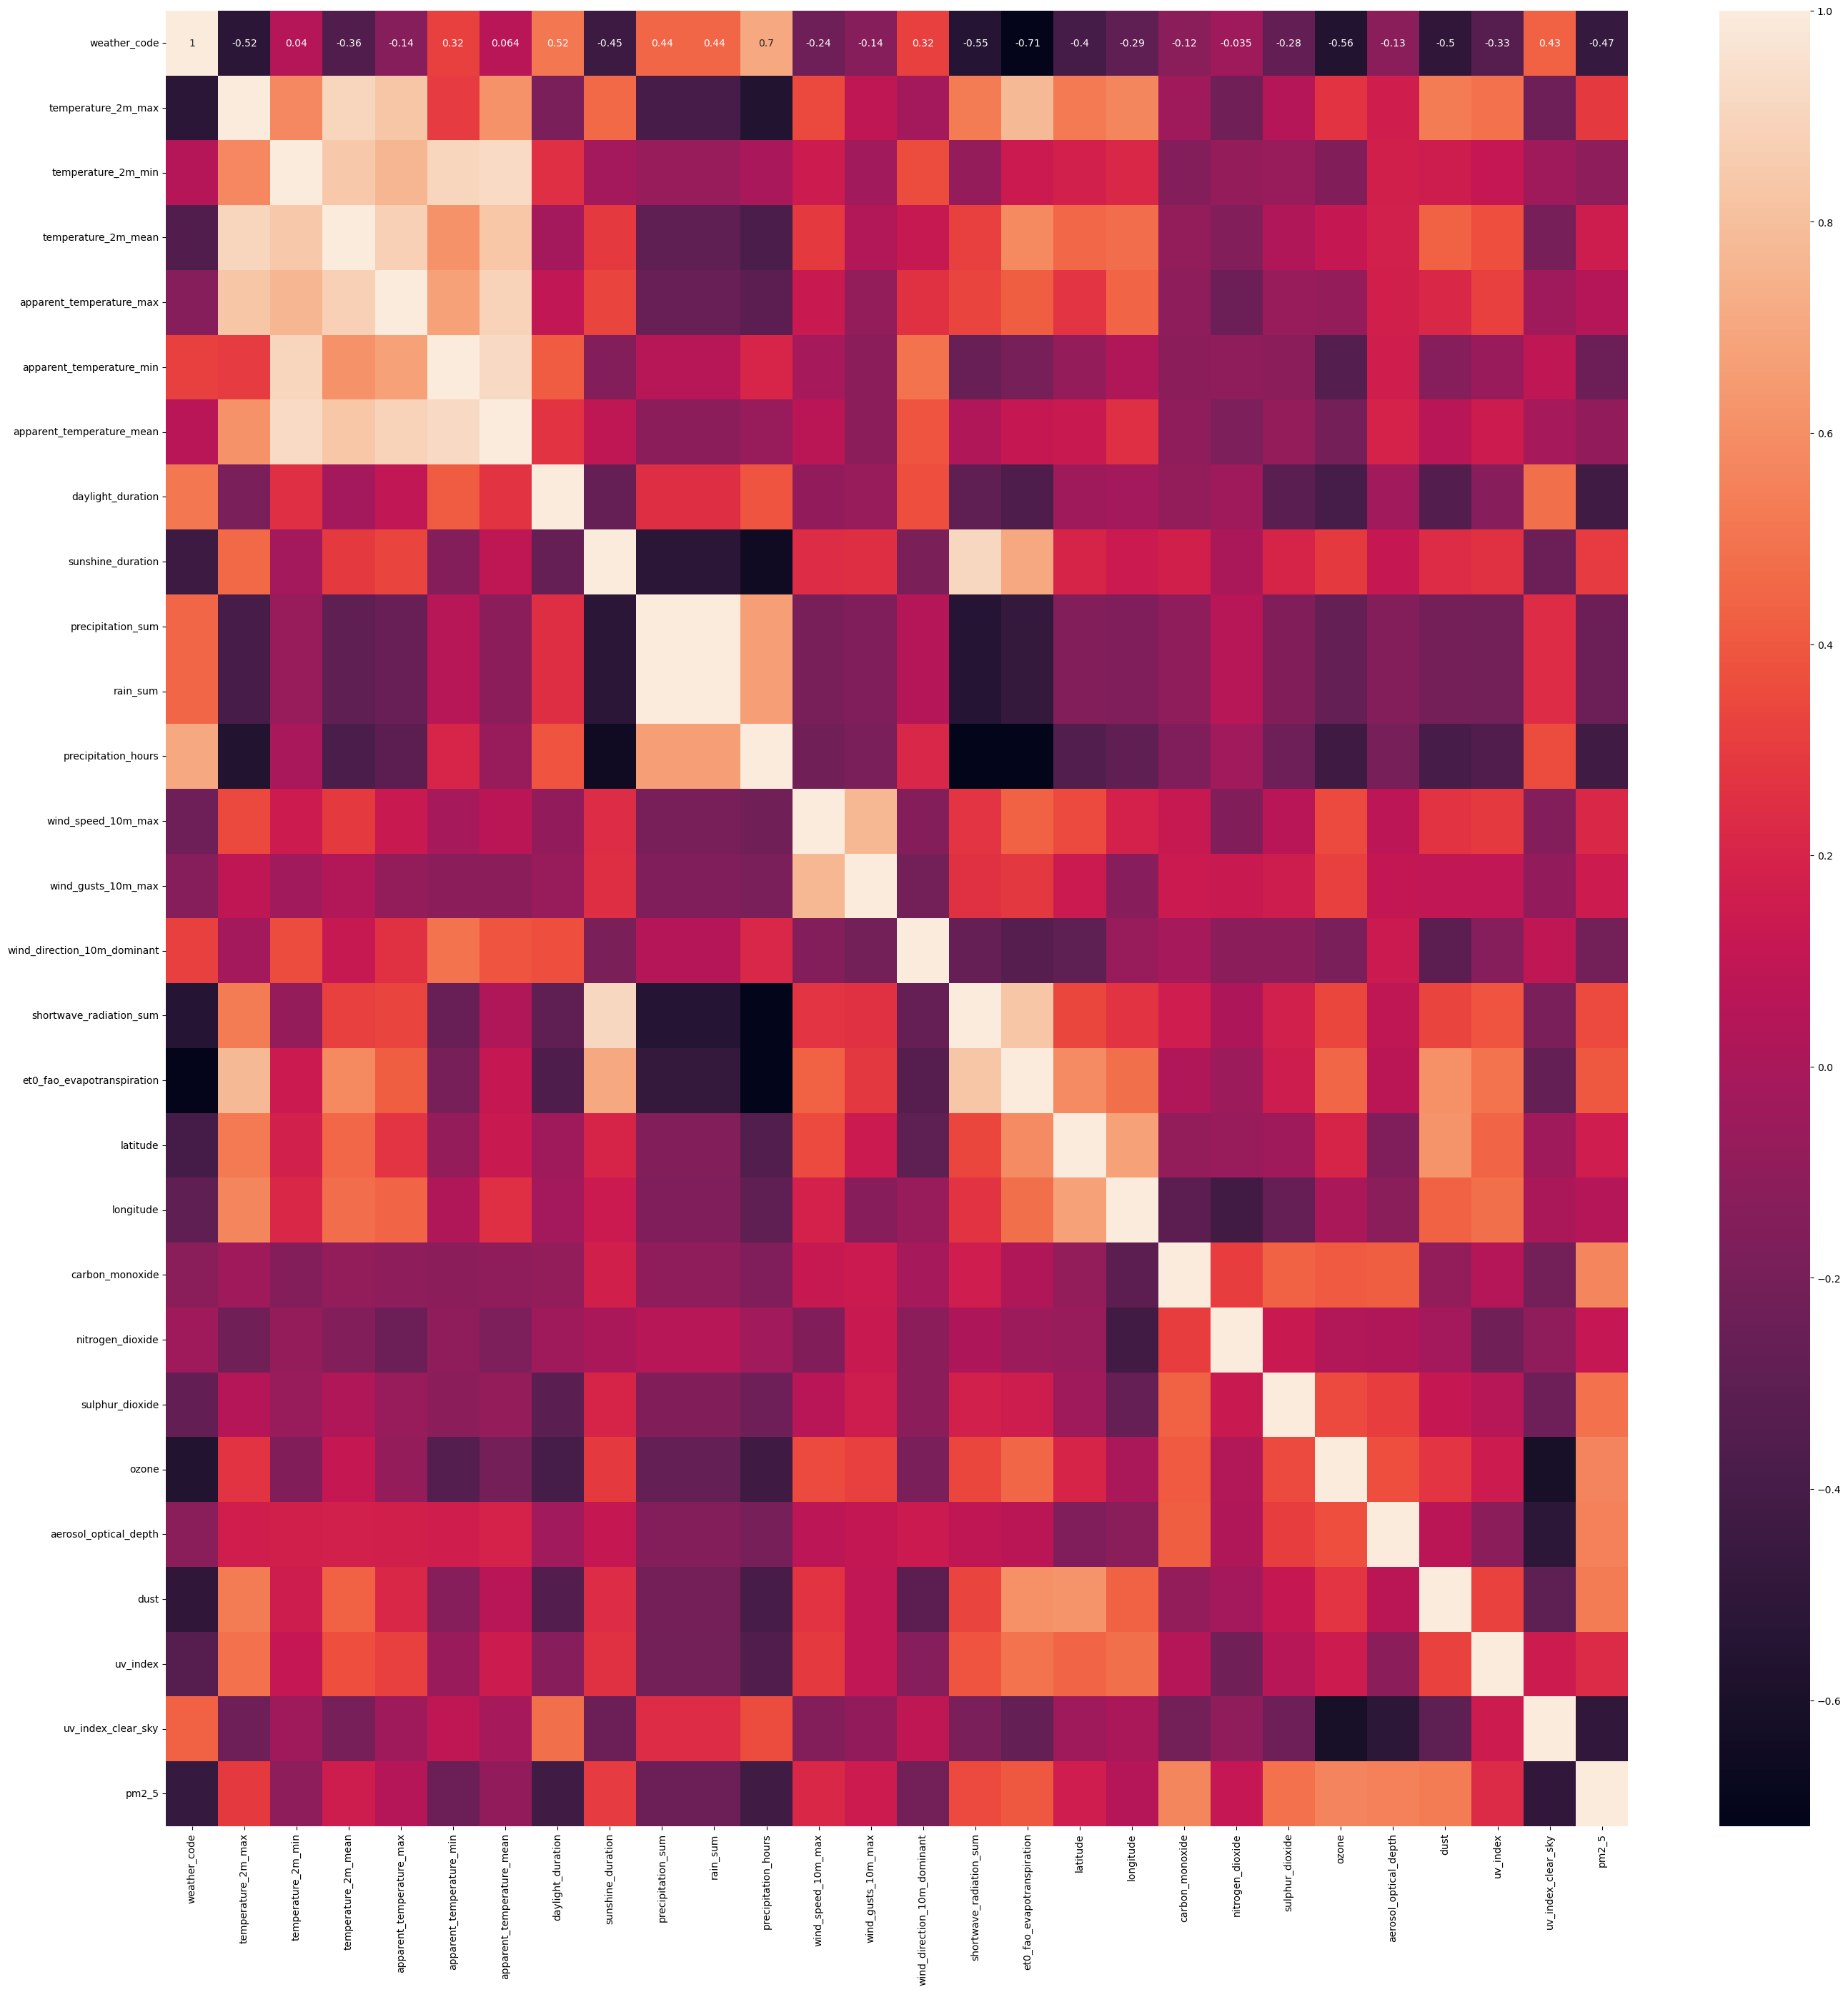

In [34]:
plt.figure(figsize = (33, 33))
sns.heatmap(train_data[features + ['pm2_5']].corr(), annot = True)

#train_data[features + ['pm2_5']].corr()['dust'].sort_values(ascending = False)

The correlation heatmap is unusable because there are too many features to visualize. We need to find a better way to see how our features interact with each other.

# Dimensionality Reduction

In [35]:
train_data.columns

Index(['date', 'weather_code', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean',
       'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'city',
       'latitude', 'longitude', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'aerosol_optical_depth', 'dust', 'uv_index',
       'uv_index_clear_sky', 'category'],
      dtype='object')

In [12]:
train_data.drop('category', axis = 1, inplace = True)

In [14]:
train_data.drop('id', axis = 1, inplace = True)

In [15]:
train_data.head()

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,...,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,1.0,27.323000,14.823000,20.573002,25.777689,14.690771,19.505260,42512.060,39178.336,0.0,...,10.4179,32.275000,324.541667,1.706250,1.164583,90.208333,0.277083,9.916667,2.185417,2.189583
1,1.0,29.528000,17.528000,23.321753,32.480470,18.525795,24.953913,42679.710,38229.746,0.0,...,13.6833,12.837500,312.500000,0.118750,0.231250,57.791667,0.343333,2.958333,1.581250,1.979167
2,65.0,23.773000,15.323000,18.233418,24.630080,16.138641,19.608873,43399.082,35278.305,20.8,...,10.4179,20.445833,232.000000,1.827083,0.347917,54.416667,0.249167,16.625000,1.970833,2.566667
3,1.0,32.478000,19.227999,25.419668,35.235100,21.212915,27.534365,42961.850,39371.730,0.0,...,13.6833,30.583333,381.375000,0.358333,0.491667,53.958333,0.446667,3.333333,2.075000,2.218750
4,3.0,39.858498,28.508501,33.854332,42.387520,30.281784,35.202442,44445.875,36486.420,0.0,...,13.4000,38.733333,307.833333,1.429167,0.454167,61.500000,0.697500,74.916667,1.783333,2.170833


In [16]:
test_data.head()

,id,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,...,latitude,longitude,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,4120,51.0,27.653000,22.603000,24.663420,32.916840,26.624214,28.979774,44176.977,30192.930000,...,4.0483,9.7043,211.583333,1.691667,0.470833,49.291667,0.156667,0.00,0.731250,2.456250
1,4121,51.0,27.703001,23.003000,24.994665,31.993069,27.470306,29.261251,44165.953,36264.550000,...,4.0483,9.7043,231.250000,1.835417,0.575000,52.583333,0.212917,0.00,1.331250,2.427083
2,4122,53.0,27.053000,22.703001,24.669664,30.781746,27.370565,28.761404,44154.860,27373.422000,...,4.0483,9.7043,211.000000,1.608333,0.477083,53.791667,0.278750,0.00,1.216667,2.237500
3,4123,63.0,23.903000,21.803000,23.113413,28.589420,24.979030,26.937243,44109.234,117.297935,...,4.0483,9.7043,296.375000,2.647917,0.554167,55.541667,0.378750,0.00,0.785417,2.316667
4,4124,3.0,28.903000,22.803000,25.580086,33.672410,27.472706,29.889349,44024.367,38393.633000,...,4.0483,9.7043,239.875000,1.652083,0.216667,58.583333,0.663750,0.25,1.252083,1.787500


In [17]:
id = test_data['id']
test_data.drop('id', axis = 1, inplace = True)

## Numerical and Categorical feature

In [21]:
categorical_features = [col for col in list(test_data.select_dtypes('object'))]
numeric_features = [col for col in list(test_data.select_dtypes(['Int64', 'float64']))]

print("------------ Categorical columns---------------\n")
print(categorical_features)
print("\n------------ Numeric columns-------------------\n")
print(numeric_features)

------------ Categorical columns---------------

['city']

------------ Numeric columns-------------------

['weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'daylight_duration', 'sunshine_duration', 'precipitation_sum', 'rain_sum', 'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'latitude', 'longitude', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'aerosol_optical_depth', 'dust', 'uv_index', 'uv_index_clear_sky']


## Log Transformation

In [22]:
train_data[numeric_features] = np.log1p(train_data[numeric_features])
test_data[numeric_features] = np.log1p(test_data[numeric_features])

## Scaling

In [25]:
scaler = StandardScaler()

train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features] = scaler.transform(test_data[numeric_features])

## Encoding City

In [27]:
encoder = LabelEncoder()

train_data['city'] = encoder.fit_transform(train_data['city'])
test_data['city'] = encoder.transform(test_data['city'])

In [28]:
train_data.head()

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,...,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,-1.706789,-0.326061,-1.646584,-0.877784,-1.451909,-1.491115,-1.596606,-1.160227,0.354645,-0.999360,...,-0.700248,32.275000,0.829143,0.103712,1.617332,2.003748,-0.211374,0.349270,0.924848,-0.812608
1,-1.706789,0.245529,-0.621099,0.030931,0.262696,-0.498682,-0.060564,-0.965683,0.331038,-0.999360,...,1.105161,12.837500,0.703719,-1.616957,-0.526688,0.618402,0.219284,-0.335162,-0.156428,-1.466099
2,0.715822,-1.347099,-1.444432,-1.747589,-1.788104,-1.090523,-1.563750,-0.139495,0.253653,1.830851,...,-0.700248,20.445833,-0.283809,0.188799,-0.182662,0.431901,-0.399579,0.672456,0.566287,0.257362
3,-1.706789,0.948822,-0.050685,0.657845,0.869549,0.086518,0.557310,-0.640002,0.359388,-0.999360,...,1.105161,30.583333,1.364606,-1.238977,0.202419,0.405701,0.850327,-0.274095,0.743470,-0.725445
4,-1.226531,2.467772,2.402983,2.757232,2.252201,1.640373,2.108843,1.038589,0.286084,-0.999360,...,0.965320,38.733333,0.653812,-0.106690,0.105664,0.811360,2.211860,1.657691,0.231105,-0.869063


In [29]:
test_data.head()

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,daylight_duration,sunshine_duration,precipitation_sum,...,latitude,longitude,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,0.550635,-0.237742,0.951977,0.437789,0.362086,1.076025,0.879417,0.738635,0.103728,-0.831929,...,-0.724573,-1.163476,-0.588973,0.093187,0.148971,0.125772,-1.054690,-1.263390,-2.210042,-0.043759
1,0.550635,-0.224449,1.061174,0.534963,0.150140,1.212951,0.940334,0.726299,0.280209,-0.831929,...,-0.724573,-1.163476,-0.294538,0.194532,0.408998,0.325772,-0.650340,-1.263390,-0.680174,-0.124908
2,0.576784,-0.399091,0.979449,0.439632,-0.136957,1.197022,0.831763,0.713882,0.009305,0.176960,...,-0.724573,-1.163476,-0.598117,0.031928,0.165084,0.396120,-0.200269,-1.263390,-0.939299,-0.669827
3,0.694501,-1.307194,0.727919,-0.034254,-0.685549,0.797339,0.419452,0.662780,-5.234420,2.086574,...,-0.724573,-1.163476,0.527999,0.685336,0.358397,0.495301,0.440876,-1.263390,-2.051647,-0.438496
4,-1.226531,0.087818,1.006805,0.703713,0.531193,1.213333,1.074248,0.567586,0.335159,-0.999360,...,-0.724573,-1.163476,-0.173198,0.064329,-0.571967,0.660598,2.040854,-1.112842,-0.857803,-2.102850


## Creating Features

In [30]:
y = train_data['pm2_5']
X = train_data.drop('pm2_5', axis = 1)

In [31]:
y

0       32.275000
1       12.837500
2       20.445833
3       30.583333
4       38.733333
          ...    
4115    18.579167
4116     4.458333
4117    15.787500
4118    24.787500
4119    21.204167
Name: pm2_5, Length: 4120, dtype: float64

In [32]:
X.isnull().sum()

weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
city                           0
latitude                       0
longitude                      0
carbon_monoxide                0
nitrogen_dioxide               0
sulphur_dioxide                0
ozone                          0
aerosol_optical_depth          0
dust                           0
uv_index                       0
uv_index_clear_sky             0
dtype: int64

## Training Pipeline

### Train test split

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [64]:
xgbc_params = {   # 'tree_method': "gpu_hist",  # Use GPU for faster training (if available)
                    'objective': 'reg:squarederror',  # Objective function for regression
                    'eval_metric': 'rmse',  # Evaluation metric
                    'random_state': 42,  # Random state for reproducibility
                    'colsample_bytree': 0.4,  # Subsample ratio of columns when constructing each tree
                    'learning_rate': 0.04,  # Learning rate
                    'max_depth': 11,  # Maximum depth of the trees
                    'n_estimators': 1100,  # Number of boosted trees (you can use early stopping to find the best number)
                    'reg_alpha': 0.8,  # L1 regularization term on weights
                    'reg_lambda': 0.65,  # L2 regularization term on weights
                    'min_child_weight': 11,  # Minimum sum of instance weight needed in a child
                    'verbosity': 0  # Set to 0 for silent running
            }



xgbc1_params = {
    'n_estimators': 1312,
    #'tree_method':  "gpu_hist",
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'learning_rate': 0.018279520260162645,
    'gamma': 0.0024196354156454324,
    'reg_alpha': 0.9025931173755949,
    'reg_lambda': 0.06835667255875388,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.883274050086088,
    'colsample_bytree': 0.6579828557036317, 
    'verbosity': 0
}



lgbm_params = {
    "objective": "regression",  # Objective function for the model (regression)
    "metric": "rmse",  # Evaluation metric (RMSE)
    "verbosity": -1,  # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",  # Gradient boosting type
    "random_state": 42,  # Random state for reproducibility
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,  # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,  # L2 regularization term
    'max_depth': 10,  # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,  # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26,  # Minimum number of data needed in a leaf
 # Use GPU for faster training (if available)
    'verbosity': 0
}




# lgbmc_params = {
#     "objective": "multiclass",          # Objective function for the model
#     "metric": "multi_logloss",          # Evaluation metric
#     "verbosity": -1,                    # Verbosity level (-1 for silent)
#     "boosting_type": "gbdt",            # Gradient boosting type
#     "random_state": 42,       # Random state for reproducibility
#     "num_class": 7,                     # Number of classes in the dataset
#     'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
#     'n_estimators': 500,                # Number of boosting iterations
#     'lambda_l1': 0.009667446568254372,  # L1 regularization term
#     'lambda_l2': 0.04018641437301800,   # L2 regularization term
#     'max_depth': 10,                    # Maximum depth of the trees
#     'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
#     'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
#     'min_child_samples': 26             # Minimum number of data needed in a leaf
# }
    
xgbc2_params =  {       'max_depth': 10, 
                        'n_estimators': 1224, 
                        'gamma': 0.8323134488556143, 
                        'reg_alpha': 0.9211957174104992, 
                        'reg_lambda': 0.8522905506401445, 
                        'min_child_weight': 4, 
                        'subsample': 0.9232723357974977, 
                        'colsample_bytree': 0.4785000546841373, 
                        'learning_rate': 0.06435693511798936,
                        'objective': 'reg:squarederror',  # Objective function for regression
                        'eval_metric': 'rmse',  # Evaluation metric
                        'verbosity': 0
         }

In [65]:
regressors = [  ("XGBC", XGBR(**xgbc_params)), 
                ("XGBC1", XGBR(**xgbc1_params)), 
                ("XGBC2", XGBR(**xgbc2_params)),
                #("CBC", CBC(**cbc_params)),
                ("LGBMC", LGBMR(**lgbm_params))
]

In [66]:
X.shape, test_data.shape

((4120, 28), (1030, 28))

## Cross Validation

In [67]:
# Define the custom RMSLE function
def custom_rmse(y_val, y_pred):
    return np.sqrt(mean_squared_error(y_val, y_pred))

# Create a custom scorer for RMSLE
custom_rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)

results = []
mean_test_rmsle_scores = []
regressor_names = []

for model_name, model in regressors:

    print(f"For {model_name}: ")

    # Steps creation
    steps = list()

    steps.append((model_name, model))
    pipeline = Pipeline(steps=steps)

    cv = KFold(n_splits = 10, shuffle=True, random_state = 42)

    # Cross Validation with the custom RMSLE scorer
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=custom_rmse_scorer, n_jobs=-1, return_train_score=True)

    print(f" Successful Cross-validation for {model_name}")
    print('*' * 50)

    # Add results to the lists
    results.append({
        "Model Name": model_name,
        "Mean Train RMSLE Score": np.mean(cv_results['train_score']),
        "Mean Test RMSLE Score": np.mean(cv_results['test_score'])
    })

    mean_test_rmsle_scores.append(np.mean(cv_results['test_score']))
    regressor_names.append(model_name)

    # DataFrame of results
results_df = pd.DataFrame(results)

# Display the DataFrame
display(results_df)

For XGBC: 
 Successful Cross-validation for XGBC
**************************************************
For XGBC1: 
 Successful Cross-validation for XGBC1
**************************************************
For XGBC2: 
 Successful Cross-validation for XGBC2
**************************************************
For LGBMC: 
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warn

[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

,Model Name,Mean Train RMSLE Score,Mean Test RMSLE Score
0,XGBC,-0.298417,-3.590044
1,XGBC1,-1.362706,-3.390571
2,XGBC2,-0.296525,-3.532196
3,LGBMC,-2.028664,-3.635434


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [68]:
display(results_df)

,Model Name,Mean Train RMSLE Score,Mean Test RMSLE Score
0,XGBC,-0.298417,-3.590044
1,XGBC1,-1.362706,-3.390571
2,XGBC2,-0.296525,-3.532196
3,LGBMC,-2.028664,-3.635434


## Inference Pipeline

In [69]:
#Defining our models...
XGBR0 = XGBR(**xgbc_params)
XGBR1 = XGBR(**xgbc1_params)
XGBR2 = XGBR(**xgbc2_params)
LGBMR0 = LGBMR(**lgbm_params)

#Fitting the models...
XGBR0.fit(X, y)
XGBR1.fit(X,y)
XGBR2.fit(X, y)
LGBMR0.fit(X,y)

[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.4097712934687264,
              lambda_l1=0.009667446568254372, lambda_l2=0.040186414373018,
              learning_rate=0.03096221154683276, max_depth=10, metric='rmse',
              min_child_samples=26, n_estimators=500, objective='regression',
              random_state=42, subsample=0.9535797422450176, verbosity=0)

## Feature Importance

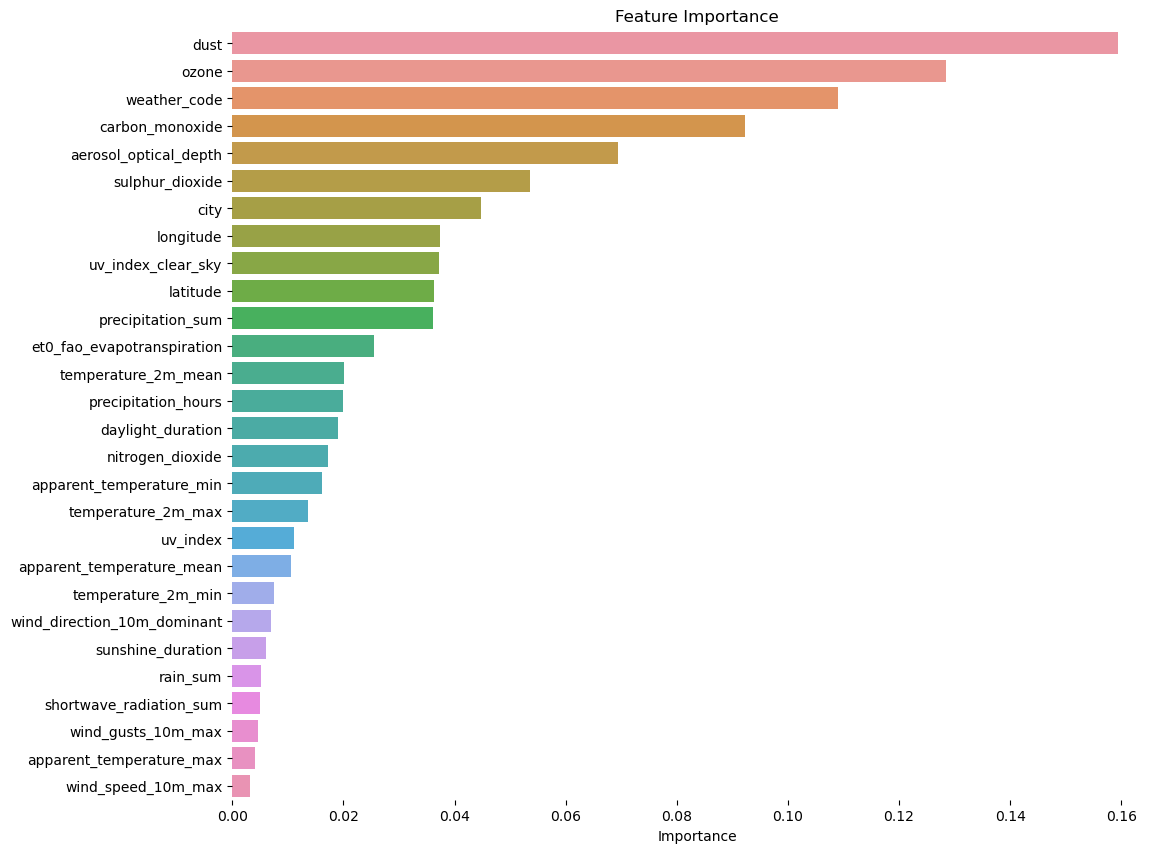

In [70]:
feature_importance = XGBR2.feature_importances_
feature_importance_df = pd.DataFrame({'Features' : X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize  = (12, 10))
sns.barplot(x = 'Importance', y = 'Features', data = feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left = True, bottom = True)
plt.show()

## Submission

In [72]:
XGBR0_pred = XGBR0.predict(test_data[X.columns]) 
XGBR1_pred = XGBR1.predict(test_data[X.columns])
XGBR2_pred = XGBR2.predict(test_data[X.columns])
LGBMR0_pred = LGBMR0.predict(test_data[X.columns])

XGBR0_pred_df = pd.DataFrame({'id': id, 'pm2_5': XGBR0_pred})
XGBR1_pred_df = pd.DataFrame({'id': id, 'pm2_5': XGBR1_pred})
XGBR2_pred_df = pd.DataFrame({'id': id, 'pm2_5': XGBR2_pred})
LGBMR0_pred_df = pd.DataFrame({'id': id, 'pm2_5': LGBMR0_pred})

voting_regressor = VotingRegressor(
    estimators=[('XGBR0', XGBR0), ('XGBR1', XGBR1), ('XGBR2', XGBR2), ('LGBMR0', LGBMR0)],
    #strategy='mean'  
)

voting_regressor.fit(X,y)
voting_regressor_pred = voting_regressor.predict(test_data[X.columns])
voting_regressor_pred_df = pd.DataFrame({'id': id, 'pm2_5': voting_regressor_pred})

XGBR0_pred_df.to_csv('XGBR0_submission.csv',   index = False)
XGBR1_pred_df.to_csv('XGBR1_submission.csv', index = False)
XGBR2_pred_df.to_csv('XGBR2_submission.csv', index = False)
LGBMR0_pred_df.to_csv('LGBMR0_submission.csv', index = False)
voting_regressor_pred_df.to_csv('submission.csv', index = False)

[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=

[LightGBM] [Warning] lambda_l2 is set=0.040186414373018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040186414373018
[LightGBM] [Warning] lambda_l1 is set=0.009667446568254372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009667446568254372
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
